<a href="https://colab.research.google.com/github/nmermigas/GCDB/blob/main/CalendAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 0. Imports

In [ ]:
import torch
import torchvision
import requests
import zipfile
import matplotlib.pyplot as plt
import copy

from pathlib import Path
from torch import nn
from torchvision import datasets,transforms

import os
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

## 1. Setting up device agnostic code

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 2. Get data

### 2.1 The GCDB dataset
- contains data from handwritten letters in Greek, both uppercase and lowercase.

In [ ]:
data_path=Path('data/')
gcdb_path = data_path / 'gcdb'

if gcdb_path.is_dir():
  print(f'{gcdb_path} directory exists')
else:
  print(f"Did not find {gcdb_path} directory, creating one...")
  gcdb_path.mkdir(parents=True, exist_ok=True)

  # Download pizza, steak, sushi data
  with open(data_path / "gcdb.zip", "wb") as f:
      request = requests.get("https://github.com/nmermigas/GCDB/raw/main/gcdb.zip")
      print("Downloading gcdb data...")
      f.write(request.content)
  # Unzip pizza, steak, sushi data
  with zipfile.ZipFile(data_path / "gcdb.zip", "r") as zip_ref:
      print("Unzipping gcdb data...")
      zip_ref.extractall(gcdb_path)
!rm $data_path/gcdb.zip

Did not find data/gcdb directory, creating one...
Unzipping gcdb data...


Creating train and test datasets out of the GCDB dataset.
Seeing the structure of the folder we downloaded, the data format is the one below:

    gcdb/
      Query/
        LETT_CAP_NORM.ALPHA/
          form_1.bmp
          form_2.bmp
          ...
        LETT_CAP_NORM.BETA/
          form_1.bmp
          form_2.bmp
          ...
        LETT_CAP_SUFF.ALPHA/
          form_1.bmp
          form_2.bmp
          ...
        LETT_CAP_SUFF.BETA/
          form_1.bmp
          form_2.bmp
          ...
        LETT_SML_NORM.ALPHA/
          form_1.bmp
          form_2.bmp
          ...
        LETT_SML_NORM.BETA/
          form_1.bmp
          form_2.bmp
          ...
        LETT_SML_SUFF.ALPHA/
          form_1.bmp
          form_2.bmp
          ...
        LETT_SML_SUFF.BETA/
          form_1.bmp
          form_2.bmp
          ...











For each of the 24 letters of the greek alphabet, there are two folders for its uppercase and 2 folders for its lowercase version.

Each folder contains `bmp` images.




Our goal is to create the following structure:


    gcdb/
      train/
        ALPHA/
          form_1.bmp
          form_2.bmp
          ...
        alpha/
          form_1.bmp
          form_2.bmp
          ...
        BETA/
          form_1.bmp
          form_2.bmp
          ...
        beta/
          form_1.bmp
          form_2.bmp
          ...
        GAMMA/
          form_1.bmp
          form_2.bmp
        ...
        gamma/
          form_1.bmp
          form_2.bmp
          ...
      test/
        ALPHA/
          form_1.bmp
          form_2.bmp
          ...
        alpha/
          form_1.bmp
          form_2.bmp
          ...
        BETA/
          form_1.bmp
          form_2.bmp
          ...
        beta/
          form_1.bmp
          form_2.bmp
          ...
        GAMMA/
          form_1.bmp
          form_2.bmp
          ...
        gamma/
          form_1.bmp
          form_2.bmp
          ...
        ...



So basically, combine the NORM and the SUFF data for each letter into one and then split them into train and test folders.

We can inspect what's in our data directory by writing a small helper function to walk through each of the subdirectories and count the files present.

To do so, we'll use Python's in-built `os.walk()`




In [ ]:
import os
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): target directory

  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [ ]:
walk_through_dir(gcdb_path)


There are 1 directories and 0 images in 'data/gcdb'.
There are 96 directories and 0 images in 'data/gcdb/Query'.
There are 0 directories and 441 images in 'data/gcdb/Query/LETT_CAP_NORM.OMIKRON'.
There are 0 directories and 456 images in 'data/gcdb/Query/LETT_CAP_NORM.THETA'.
There are 0 directories and 436 images in 'data/gcdb/Query/LETT_SML_NORM.EPSILON'.
There are 0 directories and 404 images in 'data/gcdb/Query/LETT_SML_SUFF.IOTA'.
There are 0 directories and 451 images in 'data/gcdb/Query/LETT_CAP_NORM.PSI'.
There are 0 directories and 457 images in 'data/gcdb/Query/LETT_SML_NORM.THETA'.
There are 0 directories and 456 images in 'data/gcdb/Query/LETT_CAP_NORM.ZETA'.
There are 0 directories and 442 images in 'data/gcdb/Query/LETT_SML_NORM.SIGMA'.
There are 0 directories and 430 images in 'data/gcdb/Query/LETT_SML_NORM.TAU'.
There are 0 directories and 456 images in 'data/gcdb/Query/LETT_SML_SUFF.THETA'.
There are 0 directories and 445 images in 'data/gcdb/Query/LETT_CAP_NORM.KAPA'.

It looks like we have 96 directories (4 directories * 24 letters) with each containing roughly 430 images.

Now let's combine the data for each letter.


In [ ]:
source_dir = "data/gcdb/Query"
for root, dirs, files in os.walk(source_dir):
    for dir_name in dirs:
        letter = dir_name.split(".")[1]
        case = dir_name.split('_')[1]
        print(f'{case}.{letter}')

CAP.OMIKRON
CAP.THETA
SML.EPSILON
SML.IOTA
CAP.PSI
SML.THETA
CAP.ZETA
SML.SIGMA
SML.TAU
SML.THETA
CAP.KAPA
SML.KAPA
SML.FI
CAP.IOTA
SML.DELTA
CAP.XI
CAP.GAMMA
SML.KAPA
SML.HETA
SML.OMEGA
CAP.HETA
CAP.FI
CAP.ALPHA
CAP.TAU
SML.XI
CAP.LAMDA
CAP.ZETA
SML.OMIKRON
SML.LAMDA
SML.DELTA
CAP.LAMDA
SML.GAMMA
SML.FI
SML.YPSILON
SML.MI
CAP.RO
CAP.NI
CAP.EPSILON
CAP.IOTA
CAP.DELTA
SML.ZETA
SML.BETA
SML.SIGMA
SML.PSI
CAP.BETA
CAP.OMEGA
CAP.THETA
CAP.EPSILON
CAP.YPSILON
CAP.BETA
SML.NI
SML.PII
CAP.OMEGA
SML.NI
SML.ALPHA
SML.ALPHA
SML.GAMMA
CAP.RO
CAP.DELTA
SML.ZETA
SML.TAU
CAP.SIGMA
CAP.TAU
CAP.MI
CAP.ALPHA
CAP.PII
CAP.XI
SML.PII
SML.XI
SML.BETA
SML.HETA
CAP.OMIKRON
SML.KSI
CAP.YPSILON
SML.IOTA
CAP.KSI
CAP.PII
CAP.NI
SML.OMEGA
SML.EPSILON
CAP.KSI
CAP.KAPA
CAP.MI
CAP.GAMMA
SML.PSI
SML.MI
SML.RO
SML.YPSILON
CAP.SIGMA
SML.RO
CAP.PSI
CAP.FI
SML.LAMDA
SML.OMIKRON
SML.KSI
CAP.HETA


In [ ]:
gcdb_path_full = gcdb_path / 'Query'
gcdb_path_full

PosixPath('data/gcdb/Query')

Creating the train test directories

In [ ]:
# Setup train and testing paths
train_dir = gcdb_path / "train"
test_dir =  gcdb_path / "test"

train_dir, test_dir

train_dir.mkdir(parents=True, exist_ok=True)
test_dir.mkdir(parents=True, exist_ok=True)

### 2.2 Visualizing a random image

CAP NI


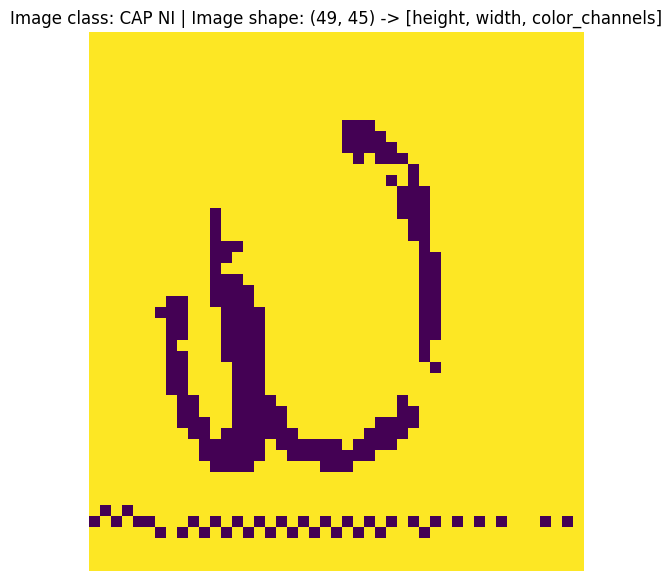

In [ ]:
import random
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt


# random.seed(42)

image_path_list = list(gcdb_path.glob("*/*/*.bmp"))
# print(image_path_list[:10])

random_image_path = random.choice(image_path_list)
# print(str(random_image_path))
# print(str(random_image_path).split('_')[1])
# print(str(random_image_path).split('.')[1].split(('/'))[0])

image_label = f'{str(random_image_path).split("_")[1]} {str(random_image_path).split(".")[1].split("/")[0]}'
print(image_label)

img = Image.open(random_image_path)

# print(f"Random image path: {random_image_path}")
# print(f"Image class: {image_label}")
# print(f"Image height: {img.height}")
# print(f"Image width: {img.width}")
# img

img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_label} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);
# print(str(random_image_path).split('_')[1] + str(random_image_path).split('.')[0] )

In [ ]:
import os
import shutil
import random

# Define source and target directories
source_dir = "data/gcdb/Query"
train_dir = "data/gcdb/train"
test_dir = "data/gcdb/test"

train_percentage = 0.8

for root, dirs, files in os.walk(source_dir):
  print(dirs)
  for dir in dirs:
    print(f"\nAccessing directory: {dir}")

    target_train_dir = os.path.join(train_dir,dir)
    os.makedirs(target_train_dir, exist_ok=True)
    target_test_dir = os.path.join(test_dir,dir)
    os.makedirs(target_test_dir,exist_ok=True)

    image_files = [f for f in os.listdir(os.path.join(source_dir,dir))]
    # print(f'Number of images before moving to train file: {len(image_files)}')

    num_train_images = int(len(image_files) * train_percentage)
    # print(f'Moving {num_train_images} to train file')

    train_images = random.sample(image_files, num_train_images)
    # print(num_train_images)
    for img in train_images:
      img_path = os.path.join(source_dir,dir,img)
      img_train_path = os.path.join(train_dir,dir,img)
      # print(img_path)
      # print(os.path.join(train_dir,dir,img))
      shutil.move(img_path, img_train_path)
    image_files_after = [f for f in os.listdir(os.path.join(source_dir,dir))]
    # print(f'Number of images after moving to train file: {len(image_files_after)}')
    for img in image_files_after:
      img_path = os.path.join(source_dir,dir,img)
      img_test_path = os.path.join(test_dir,dir,img)
      # print(img_path)
      # print(os.path.join(train_dir,dir,img))
      shutil.move(img_path, img_test_path)
    # print(f'Number of images after the split: {len([f for f in os.listdir(os.path.join(source_dir,dir))])}')

## 3. Transforming data

1. Turn the images into tensors.
2. Turn them into a `Dataset` and then into a `DataLoader`

In [ ]:
# Write transform for image
data_transform = transforms.Compose([
    # Resize the images to 64x64
    transforms.Resize(size=(1024, 1024)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.3), # p = probability of flip, 0.5 = 50% chance
    # Turn the image into a torch.Tensor
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0
])

### 3.1 Creating DataLoaders.


In [ ]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir, # target folder of images
                                  transform=data_transform, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 34301
    Root location: data/gcdb/train
    StandardTransform
Transform: Compose(
               Resize(size=(1024, 1024), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.3)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 8630
    Root location: data/gcdb/test
    StandardTransform
Transform: Compose(
               Resize(size=(1024, 1024), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.3)
               ToTensor()
           )


In [ ]:
# Get class names as a list
class_names = train_data.classes
class_names

In [ ]:
# Can also get class names as a dict
class_dict = train_data.class_to_idx
class_dict

In [ ]:
# Check the lengths
len(train_data), len(test_data)

(34301, 8630)

In [ ]:
# train_data[15][0]
len(train_data[0][0])

3

In [ ]:
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]])
Image shape: torch.Size([3, 1024, 1024])
Image datatype: torch.float32
Image label: 0
Label datatype: <class 'int'>


Original shape: torch.Size([3, 1024, 1024]) -> [color_channels, height, width]
Image permute shape: torch.Size([1024, 1024, 3]) -> [height, width, color_channels]


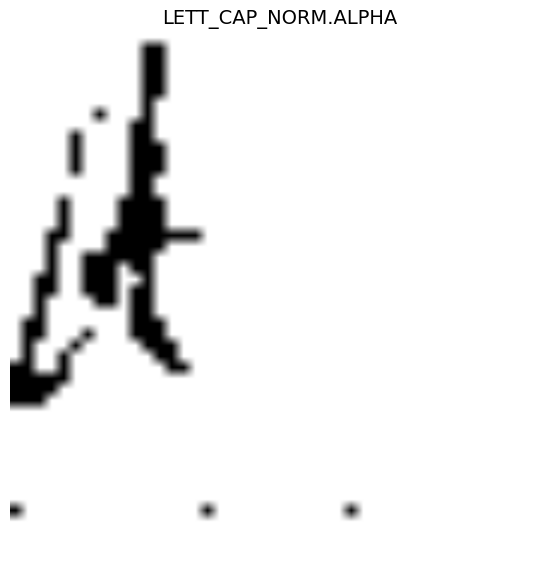

In [ ]:
# Rearrange the order of dimensions
img_permute = img.permute(1, 2, 0)

# Print out different shapes (before and after permute)
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute shape: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img.permute(1, 2, 0))
plt.axis("off")
plt.title(class_names[label], fontsize=14);

In [ ]:
# Turn train and test Datasets into DataLoaders
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=1, # how many samples per batch?
                              num_workers=os.cpu_count(), # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True) # shuffle the data?

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=1,
                             num_workers=1,
                             shuffle=False) # don't usually need to shuffle testing data

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7df34f6a4070>,
 <torch.utils.data.dataloader.DataLoader at 0x7df34f6a6c20>)

In [ ]:
img, label = next(iter(train_dataloader))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")
print(f"Label {label}")

Image shape: torch.Size([1, 3, 1024, 1024]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])
Label tensor([61])


In [ ]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [ ]:
# 1. Take in a Dataset as well as a list of class names
def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):

    # 2. Adjust display if n too high
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")

    # 3. Set random seed
    if seed:
        random.seed(seed)

    # 4. Get random sample indexes
    random_samples_idx = random.sample(range(len(dataset)), k=n)

    # 5. Setup plot
    plt.figure(figsize=(16, 8))

    # 6. Loop through samples and display random samples
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # 7. Adjust image tensor shape for plotting: [color_channels, height, width] -> [color_channels, height, width]
        targ_image_adjust = targ_image.permute(1, 2, 0)

        # Plot adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        if classes:
            title = f"class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)

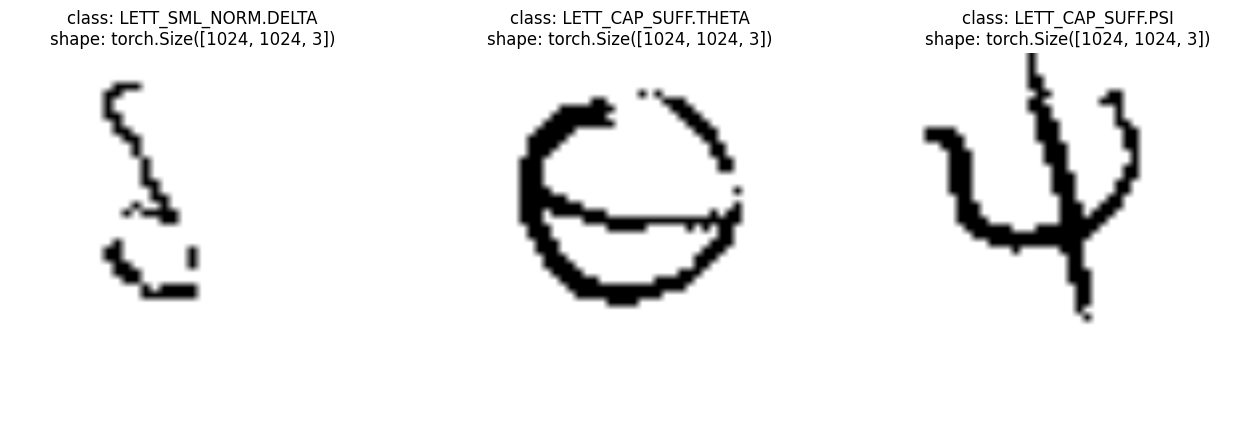

In [ ]:
# Display random images from ImageFolder created Dataset
display_random_images(train_data,
                      n=3,
                      classes=class_names,
                      seed=None)

In [ ]:
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31), # how intense
    transforms.ToTensor() # use ToTensor() last to get everything between 0 & 1
])

# Don't need to perform augmentation on the test data
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

OSError: not supported for this image mode

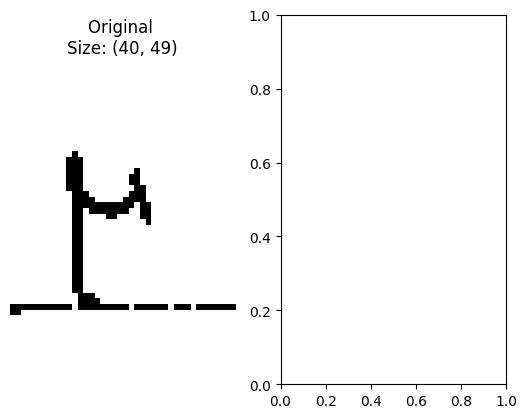

In [ ]:
# Get all image paths
image_path_list = list(gcdb_path.glob("*/*/*.bmp"))
# Plot random images
plot_transformed_images(
    image_paths=image_path_list,
    transform=train_transforms,
    n=3,
    seed=None
)

In [ ]:
import matplotlib.pyplot as plt
import torch
import torchvision
import copy

from torch import nn
from torchvision import datasets,transforms
from pathlib import Path

device = "cuda" if torch.cuda.is_available() else "cpu"
device

data_dir = Path('data')

# emnist_train_transforms = transforms.Compose([
#     transforms.ToTensor(),  # Convert image to tensor
#     transforms.Normalize((0.5,), (0.5,))  # Normalize pixel values to [-1, 1]
# ])

# Get EMNIST training data
emnist_data = datasets.EMNIST(root=data_dir,
                                       split='letters',
                                       train= True,
                                       download = True)

# emnist_test_data = datasets.EMNIST(root=data_dir,
#                                    split='balanced',
#                                    train=False,
#                                    download=True)


  4%|▎         | 20414464/561753746 [00:01<00:51, 10552754.30it/s]


KeyboardInterrupt: 

In [ ]:
print(f'Data size: {emnist_data.data.shape}')

images = emnist_data.data.view([emnist_data.data.shape[0],1,emnist_data.data.shape[1],emnist_data.data.shape[2]]).float()

print(f'Tensor data: {images.shape}')

Data size: torch.Size([124800, 28, 28])
Tensor data: torch.Size([124800, 1, 28, 28])


In [ ]:
emnist_data.class_to_idx

{'N/A': 0,
 'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26}

In [ ]:
letterCategories = emnist_data.classes[1:]
labels = copy.deepcopy(emnist_data.targets)-1
print(labels.shape)

torch.Size([124800])


In [ ]:
labels.unique()

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25])

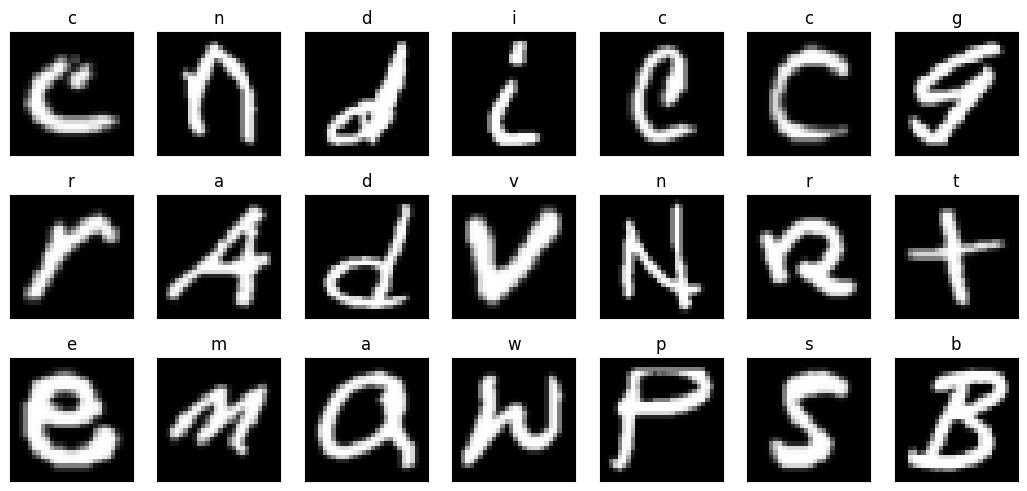

In [ ]:
# visualize

fig, axs = plt.subplots(3,7, figsize=(13,6))

for i, ax in enumerate(axs.flatten()):
  pic = np.random.randint(images.shape[0])

  image = np.squeeze(images[pic,:,:])
  letter = letterCategories[labels[pic]]

  ax.imshow(image.T,cmap='gray')
  ax.set_title(f"{letter}")
  ax.set_xticks([])
  ax.set_yticks([])
plt.show()

### Create train/test sets

In [ ]:
import os
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

num_workers = os.cpu_count()
print(num_workers)

train_data, test_data, train_labels, test_labels = train_test_split(images, labels, test_size=.1)

train_data = TensorDataset(train_data,train_labels)
train_data = TensorDataset(test_data,test_labels)

batch_size = 32
train_dataloader = DataLoader(train_data,
                              batch_size=batch_size,
                              shuffle=True,
                              num_workers=num_workers,
                              pin_memory=True)
test_dataloader = DataLoader(test_data,
                              batch_size=batch_size,
                              shuffle=False,
                              num_workers=num_workers,
                              pin_memory=True)


2


In [ ]:
train_dataloader,test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7cce096f5930>,
 <torch.utils.data.dataloader.DataLoader at 0x7cce096f5900>)

In [ ]:
img, label = next(iter(train_dataloader))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([32, 1, 28, 28]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([32])


In [ ]:
print(train_dataloader.dataset.tensors[0].shape)
print(train_dataloader.dataset.tensors[1].shape)


torch.Size([12480, 1, 28, 28])
torch.Size([12480])


In [ ]:
uppercase_letters = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
lowercase_letters = "abcdefghijklmnopqrstuvwxyz"

# Iterate through the directories
for letter in uppercase_letters + lowercase_letters:
  print(letter)

A
B
C
D
E
F
G
H
I
J
K
L
M
N
O
P
Q
R
S
T
U
V
W
X
Y
Z
a
b
c
d
e
f
g
h
i
j
k
l
m
n
o
p
q
r
s
t
u
v
w
x
y
z
